In [42]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

from GradCam import GradCAM

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
test = pd.read_csv('glaucoma_test.csv')
test

,filename,label,path,label_encoded
0,Im099.jpg,normal,RIMONE_r2/Normal/Im099.jpg,0
1,Im0330_ORIGA.jpg,normal,ORIGA_NORMAL/Im0330_ORIGA.jpg,0
2,Im0165_ORIGA.jpg,normal,ORIGA_NORMAL/Im0165_ORIGA.jpg,0
3,NL_149.png,normal,kaggle_ds/1_normal/NL_149.png,0
4,Im0092_ORIGA.jpg,normal,ORIGA_NORMAL/Im0092_ORIGA.jpg,0
...,...,...,...,...
195,Im0554_g_ORIGA.jpg,glaucoma,ORIGA_GLAUCOMA/Im0554_g_ORIGA.jpg,1
196,Im017.bmp,glaucoma,RIMONE_r1/Early/Im017.bmp,1
197,Im0550_g_ORIGA.jpg,glaucoma,ORIGA_GLAUCOMA/Im0550_g_ORIGA.jpg,1
198,Im013.bmp,glaucoma,RIMONE_r1/Deep/Im013.bmp,1


In [4]:
IMG_DIM = 380
BATCH_SIZE = 8

def import_image(path, label):
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [IMG_DIM, IMG_DIM])

    return img, label

labels = tf.one_hot(test['label_encoded'], depth=2)
test_ds = tf.data.Dataset.from_tensor_slices((test['path'], labels)).cache()
test_ds = test_ds.map(import_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [5]:
HUB_MODEL = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'

hub.load(HUB_MODEL)
hub_model = tf.keras.models.load_model(hub.resolve(HUB_MODEL))
hub_model._name = 'efficientnet_b4'

model = tf.keras.Sequential([
    hub_model,
    tf.keras.layers.Dense(2)
])

model.build([None, IMG_DIM, IMG_DIM, 3])  # Batch input shape.

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['acc']
)

In [7]:
model.load_weights('glaucoma_publish010')

In [8]:
model.evaluate(test_ds)

25/25 [==============================] - 1s 52ms/step - loss: 0.7432 - acc: 0.7450


[0.7432024478912354, 0.7450000047683716]

In [9]:
logits = model.predict(test_ds)

In [10]:
probs = tf.nn.softmax(logits).numpy()
preds = np.argmax(probs, axis=1)
labels = test['label_encoded'].values

In [50]:
report = classification_report(labels, preds, output_dict=True)
report['1']

{'precision': 0.7289719626168224,
 'recall': 0.78,
 'f1-score': 0.7536231884057971,
 'support': 100}

In [46]:
con_matrix = confusion_matrix(labels, preds)
con_matrix

array([[71, 29],
       [22, 78]])

ROC (area under the curve):  0.8453


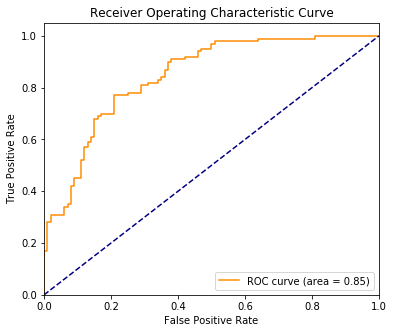

In [12]:
fpr, tpr, _ = roc_curve(labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC (area under the curve): ', roc_auc)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')

In [38]:
samples = test.sample(5)
samples

,filename,label,path,label_encoded
78,Im0427_ORIGA.jpg,normal,ORIGA_NORMAL/Im0427_ORIGA.jpg,0
112,9.jpg,glaucoma,DR_HAGIS_GLAUCOMA/9.jpg,1
181,S-24-R.jpg,glaucoma,RIMONE_r3_CROPPED/S-24-R.jpg,1
169,Im330.jpg,glaucoma,RIMONE_r2/Glaucoma and glaucoma suspicious/Im3...,1
96,Im0073_ORIGA.jpg,normal,ORIGA_NORMAL/Im0073_ORIGA.jpg,0


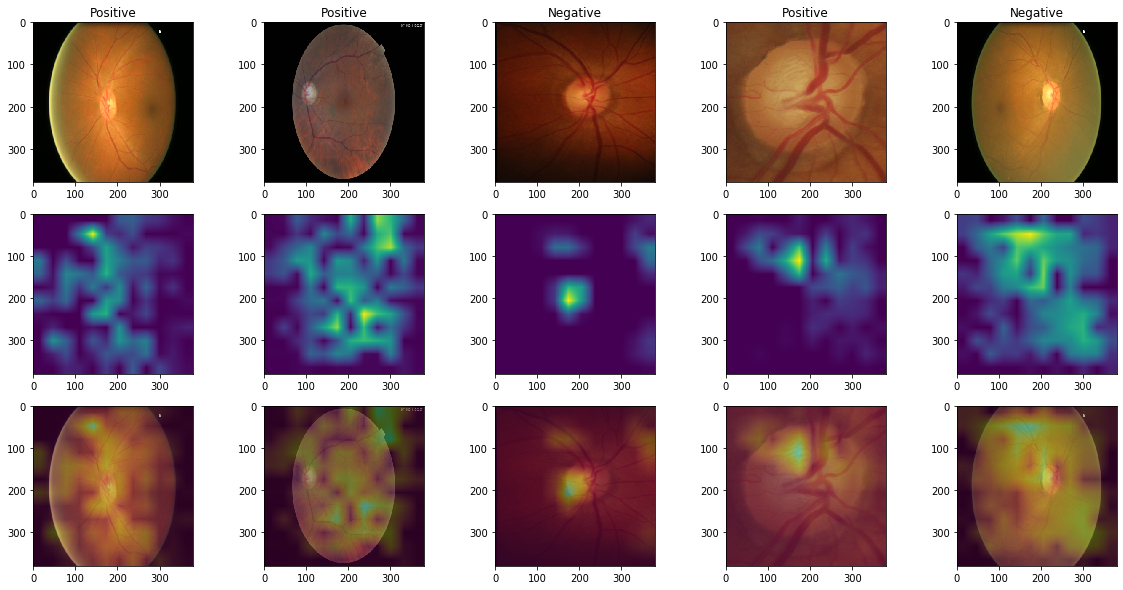

In [41]:
plt.figure(figsize=(20,10))
i = 1
j = 1
k = 1

for sample in samples['path']:
    sample_img = Image.open(sample)
    sample_img = sample_img.resize((IMG_DIM, IMG_DIM))
    sample_img = np.array(sample_img)

    logit = model.predict(np.expand_dims(sample_img, 0))
    prob = tf.nn.sigmoid(logit).numpy()
    pred = np.argmax(prob, axis=1)[0]
    cam = GradCAM(hub_model, 1)
    heatmap = cam.compute_heatmap(np.expand_dims(sample_img, 0))

    overlay_heatmap = cam.overlay_heatmap(heatmap, sample_img)[1]

    plt.subplot(3, 5, i)
    plt.imshow(sample_img)
    plt.title('Positive' if pred else 'Negative')
    plt.subplot(3, 5, 5+j)
    plt.imshow(heatmap)
    plt.subplot(3, 5, 10+k)
    plt.imshow(overlay_heatmap)

    i+=1
    j+=1
    k+=1